# Building a Model With sklearn - Lending Club

## Import necessary libraries

In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import warnings
import gc
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
%matplotlib inline

from sklearn.impute  import SimpleImputer
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, f1_score, make_scorer, confusion_matrix
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

In [2]:
pd.set_option('display.max_columns',60)

## Load Dataset

In [3]:
start_df = pd.read_csv('./loan.csv', low_memory=False)

Work with a copy of dataset to avoid having to reload:

In [4]:
df = start_df.copy(deep=True)
df.head(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,...,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,NaN,NaN,...,0.00,Jan-2015,171.62,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-1999,5.0,NaN,NaN,...,1.11,Apr-2013,119.66,NaN,Sep-2013,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,2.0,NaN,NaN,...,0.00,Jun-2014,649.91,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,Feb-1996,1.0,35.0,NaN,...,0.00,Jan-2015,357.48,NaN,Jan-2015,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-2011,Current,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0.0,Jan-1996,0.0,38.0,NaN,...,0.00,Jan-2016,67.79,Feb-2016,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Define target variable

Based on problem defined for dataset, we are building a model that will predict whether a user will defaul in future.

Therefore, we need to convert the historical loan status categories into a boolean that describes wheter or not the customer defaulted. 

In [5]:
df.loan_status.unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off', 'Issued'],
      dtype=object)

Defines which 'loan status' is considered as 'Defaulted':

In [6]:
target_list = [1 if i in ['Charged Off', 'Does not meet the credit policy. Status:Charged Off', 'Default','Late (31-120 days)','Late (16-30 days)'] else 0 for i in df['loan_status']]

Calculate how much of dataset 'Defaults' based on this description:

In [7]:
print(sum(target_list), sum(target_list)/len(target_list))

61176 0.06894010338310913


In [8]:
df['TARGET'] = target_list

In [9]:
df.drop(['id', 'loan_status' ] , axis = 1 , inplace = True)

## Sample Last 5 Years of Data
We are going to focus our analysis in the years after 2010.

In [10]:
df['issue_d'] = pd.to_datetime(df['issue_d'])
df['year'] = df['issue_d'].dt.year

In [11]:
df = df[df.year >= 2010]

In [12]:
df.drop(['issue_d', 'year'], axis=1, inplace=True)

## Handle Missing Values

Before applying any function to handle missing values we want to understand the state of each feature regarding to incomplete data to define if we can eliminate some variables which are mostly empty.

True


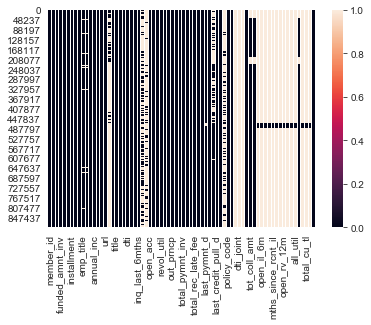

In [13]:
print(df.isnull().values.any())
sns.heatmap(df.isnull()) 

In [14]:
def null_values(df, perct_to_remove = 100):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        columns_to_remove = mis_val_table_ren_columns[mis_val_table_ren_columns['% of Total Values'] > perct_to_remove].index
        columns_to_keep = df.iloc[:,~df.columns.isin(columns_to_remove)].columns
        return mis_val_table_ren_columns , columns_to_keep 

In [15]:
cols_missing_values, col_to_keep = null_values(df , 10)

Dataframe has 72 columns.
There are 31 columns that have missing values.


In [16]:
df = df[col_to_keep]
nullCount = df.isnull().sum()
nullCount[nullCount>0]

emp_title             51016
emp_length            44825
title                   150
revol_util              442
last_pymnt_d          17640
last_credit_pull_d       50
tot_coll_amt          61999
tot_cur_bal           61999
total_rev_hi_lim      61999
dtype: int64

Text(0, 0.5, 'Data type')

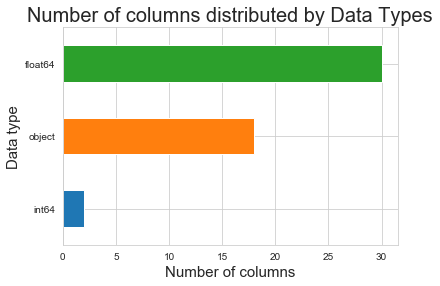

In [17]:
# Number of each type of column
df.dtypes.value_counts().sort_values().plot(kind='barh')
plt.title('Number of columns distributed by Data Types',fontsize=20)
plt.xlabel('Number of columns',fontsize=15)
plt.ylabel('Data type',fontsize=15)

## Removing Columns that have more than 10 categories

In [18]:
## Helper function to easily get columns with specific data type
def get_specific_columns(df, data_types, to_ignore = list(), ignore_target = False):
    columns = df.select_dtypes(include=data_types).columns
    if ignore_target:
        columns = filter(lambda x: x not in to_ignore, list(columns))
    return columns

In [19]:
## Save all columns with 'object' datatype (non-numerical)
obj_variables = get_specific_columns(df, ['object'], ['TARGET'], ignore_target = True)
obj = df[list(obj_variables)]

In [21]:
not_to_much_unique = df.loc[:,~df.columns.isin(obj.loc[:,obj.nunique() > 10].columns)].columns

In [22]:
df = df[not_to_much_unique]

In [23]:
df.drop(['collections_12_mths_ex_med' , 'tot_coll_amt'] , axis = 1 , inplace = True)

## Impute missing values

In [24]:
nullCount = df.isnull().sum()
nullCount[nullCount>0]

revol_util            442
tot_cur_bal         61999
total_rev_hi_lim    61999
dtype: int64

In [25]:
#### since 5 columns have the same nulls we decided to drop these 29 rows 
df = df.loc[~df[ 'delinq_2yrs' ].isnull()]

In [26]:
### here we use SimpleImputer form sklearn to impute NA, the strategy decided is median to not change the distribution since they are skewed
imp = SimpleImputer( strategy='median', verbose=1)
numericals = list(get_specific_columns(df, ['int64' , 'float64'], ['TARGET'], ignore_target = True))

num = df[numericals]

df[numericals] =imp.fit_transform(num) 

## Feature Engineering

In [27]:
# 1 
intrst_per_grade = df[['int_rate','grade']].groupby('grade').agg(['mean','std'])
dum = df[['grade','int_rate']].join(intrst_per_grade , on ='grade')
dum['intrst_per_grade'] = (dum['int_rate'] - dum[('int_rate', 'mean')]) / dum[('int_rate', 'std')]
df['intrst_per_grade']= dum['intrst_per_grade']

/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [28]:
# 2 %  last_paymnt_amnt / tot_cur_bal
df['perc_last_pay_from_bal'] = df['installment'] / (df['tot_cur_bal'] + 1)

In [29]:
# 3 [last_pay - ( tot_cur_bal + annual_income/12)] if positive  1(dsnt have wnough money to pay) if negative has 0 
df['not_engh_to_pay'] = df['installment'] - df['tot_cur_bal'] - df['annual_inc']/12
df['not_engh_to_pay'] = np.where(df['not_engh_to_pay'] > 0, 1, 0).astype('object')

## Scaling Numerical Values

In [30]:
scaler = StandardScaler()
numericals = list(get_specific_columns(df, ['int64' , 'float64'], ['TARGET' , 'member_id'], ignore_target = True))
num = df[numericals]

df[numericals] =scaler.fit_transform(num)

## Binning

In [31]:
skt = KBinsDiscretizer(n_bins = 5 , strategy = 'quantile' , encode = 'ordinal')
to_bin = np.array(df['total_pymnt']).reshape(-1, 1)
df[['total_pymnt']] = skt.fit_transform(to_bin)
df[['total_pymnt']] = df[['total_pymnt']].astype('object' , inplace =True)

## One Hot Encoding

In [32]:
def One_hot_sklearn(df , categoricals): 
    df.copy()
    for i in categoricals:
        print(i)
        hot = OneHotEncoder()
        X = hot.fit_transform(df[i].values.reshape(-1,1)).toarray()
        dfOneHot = pd.DataFrame(X, columns = [str(i)+str('_')+str(j[3:]) for j in hot.get_feature_names()])
        dfOneHot['member_id'] = df['member_id']
        df = df.merge(dfOneHot,on = 'member_id')
        df.drop(i, axis =1 , inplace = True)
    return df 

In [33]:
obj_variables = list(get_specific_columns(df, ['object'], ['TARGET'], ignore_target = True))
df = One_hot_sklearn(df , obj_variables)

term
grade
home_ownership
verification_status
pymnt_plan
initial_list_status
total_pymnt
application_type
not_engh_to_pay


# FEATURE SELECTION

Firstly we are going to present some examples of feature selection functions alone (in ascending order of complexity) to detail their characteristics to then present a combined example of how they can be used with pipeline.

## Select Kbest
The function select the k number of features according to their score.

**Parameters**

*score_func*: Function taking the target and the explanatory variables and returning a pair of arrays with the scores and p-values. Some of the options available for classification tasks are f_classif, chi2, mutual_info_classif, etc. In this case we are going to use f_classif as we are dealing with positive and negative features.

*k*: Number of the number of features to select.

In [60]:
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
warnings.filterwarnings("ignore")

df_copy = df.copy()

X,y = df_copy.loc[:,df.columns!='TARGET'], df_copy['TARGET']

X_new = SelectKBest(f_classif, k=20).fit_transform(X, y)
print("The number of features has  been  decreased from",X.shape[1],"to",X_new.shape[1])

The number of features has  been  decreased from 60 to 20


## Recursive Feature Elimination with Cross Validation
The function generate a ranking of the features by using recursive feature elimination and cross-validate them to give a more stable result.

**Parameters**

*estimator*: A supervised learning estimator with a fit method that provides information about feature importance.

*step*: Number of features to remove at each iteration.

*cv*: Defines the cross-validation strategy. By default does 3-fold cross validation.

*scoring*: String which defines the scoring strategy that will be used for the evaluation.

*n_jobs*: Determines the number of cores that run in parallel while fitting across the folds. This is important as the iterations that the cross-validation function does, depending on the application, may be computationally expensive.

Optimal number of features : 58


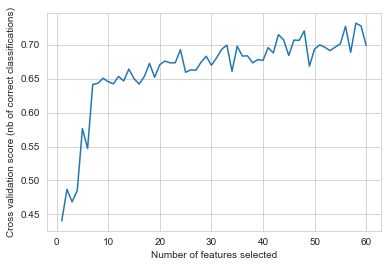

CPU times: user 2min 24s, sys: 5.66 s, total: 2min 30s
Wall time: 21min 42s


In [62]:
%%time

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

df_copy = df.copy()

X,y = df_copy.loc[:,df.columns!='TARGET'], df_copy['TARGET']

est = RandomForestClassifier()

rfecv = RFECV(estimator=est, step=1, cv=3,
              scoring='accuracy', n_jobs=-1)
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

## Variance Threshold with PCA and Feature Union Pipeline

The Variance Threshold feature selection function is an unsupervised algorithm which selects the features whose variance are above a manually defined value in order to keep just the ones which have enough variance to be useful for the model.

This function was used together with PCA which is an unsupervised algorithm which aims to decrease the dimensionality of large datasets by creating principal components in order of importance as a representation of the original features to be able to select a lower number of variables an achieve similar results.

Finally, we will apply the function Feature Union (part of the scikit learn Pipeline API). This estimator applies a list of transformer objects in parallel to the input data, then concatenates the results. Which allow us  to combine several feature extraction mechanisms into a single transformer. In this case the output will generate a new set of explanatory variables composed by the 15 features selected in the PCA and all the variables with a variance above 0.8.

**Parameters**

*PCA - n_components*: Number of principal components that will be selected.

*VarianceThreshold - threshold*: Value used as limit of variance for the feature selection.

In [65]:
%%time

from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold

df_copy = df.copy()

X,y = df_copy.loc[:,df.columns!='TARGET'], df_copy['TARGET']

pca = PCA(n_components=15)

selection = VarianceThreshold(threshold=0.8)

combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)])

# Use combined features to transform dataset:
X_features = combined_features.fit(X, y).transform(X)
print("Combined space has", X_features.shape[1], "features")

Combined space has 44 features
CPU times: user 13.2 s, sys: 2.62 s, total: 15.8 s
Wall time: 5.66 s


## Splitting Train and Test Set

In [34]:
X = df.loc[:,df.columns!='TARGET']
y = df['TARGET']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, random_state=100)

## Over Sampling

In [36]:
Xy_train = X_train.copy()
Xy_train['TARGET'] = y_train

In [37]:
defaulted = Xy_train[ Xy_train.TARGET == 1]
not_defaulted = Xy_train[Xy_train.TARGET == 0]

In [38]:
defaulted_upsampled=resample(defaulted,
                          replace=True, # sample with replacement
                          n_samples=round(0.3*len(not_defaulted)), # match number in majority class
                          random_state=42) # reproducible results

In [39]:
upsampled = pd.concat([not_defaulted, defaulted_upsampled])

In [40]:
y_train = upsampled['TARGET']
X_train = upsampled.drop(['TARGET','member_id'], axis =1 )
X_test.drop('member_id', axis =1 , inplace = True)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


## Modelling

#### Logistic Regression

In [47]:
log = LogisticRegression()

In [48]:
log.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [49]:
predLog = log.predict(X_test)

In [50]:
accuracy_score(y_test, predLog)

0.9803404817270979

In [51]:
f1_score(y_test, predLog)

0.8382311253897762

#### Random Forest Regressor

In [52]:
rf = RandomForestClassifier()

In [53]:
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [54]:
predRF = rf.predict(X_test)

In [55]:
accuracy_score(y_test, predRF)

0.9818218356156518

In [56]:
f1_score(y_test, predRF)

0.8467125012104192

### Support vector machine

In [ ]:
svc = SVC()
svc.fit(X_train,y_train)
predSVC = svc.predict(X_test)
accuracy_score(y_test, predSVC)
f1_score(y_test, predSVC)

### Neural Network

In [60]:
clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(5, 5, 5), random_state=1)

In [61]:
clf.fit(X_train, y_train) 

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 5, 5), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [62]:
predCLF = clf.predict(X_test)

In [63]:
accuracy_score(y_test, predCLF)

0.9800304309132145

In [64]:
f1_score(y_test, predCLF)

0.839560845096411

## Cross Validation and Hyperparameter Tuning

In [ ]:
## Perform grid search with multiple parameter options for Random Forest Classifier

In [66]:
# Number of trees in random forest
n_estimators = [50, 100, 200]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [100, 150]
# Minimum number of samples required to split a node
min_samples_split = [2, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [81]:
kfold = KFold(n_splits=3)


### Uncomment this and run to test all parameters
# grid_search = GridSearchCV(
#         estimator=RandomForestClassifier(),
#         param_grid=random_grid,
# #         scoring="accuracy",
#         scoring = make_scorer(f1_score)
#         cv=kfold,
#         refit=True,
#         n_jobs=-1,
#         verbose = 2,
# )

grid_search = RandomizedSearchCV(
        estimator=RandomForestClassifier(),
        param_distributions=random_grid,
#         scoring="accuracy",
        scoring = make_scorer(f1_score),
        cv=kfold,
        refit=True,
        random_state=999,
        n_iter = 1,
        n_jobs=-1,
        verbose = 2,
)

grid_result = grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  5.7min finished


In [89]:
print(
    "\tAverage result for best Random Forest: {} +/- {:.5f}".format(
        grid_result.best_score_,
        grid_result.cv_results_["std_test_score"][
            np.argmax(grid_result.cv_results_["mean_test_score"])
        ],
    )
)

	Average result for best Random Forest: 0.0 +/- 0.00000


In [83]:
grid_result.best_params_

{'n_estimators': 100,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 150,
 'bootstrap': True}

In [84]:
finalPredictions = grid_result.best_estimator_.predict(X_test)

## Metrics

#### Final Accuracy

In [85]:
accuracy_score(y_test, finalPredictions)

0.9820859529756265

#### Final F-1 Score

In [86]:
f1_score(y_test, finalPredictions)

0.8498989704608871

#### ROC Curve

0.873151162757947


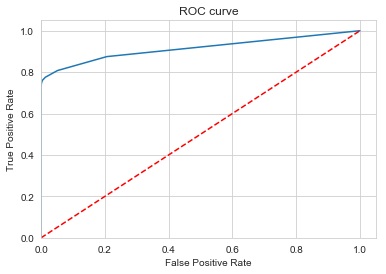

In [87]:
logit_roc_auc = roc_auc_score(y_test, finalPredictions)
print(logit_roc_auc)
fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
plt.figure()  
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show();

#### Confusion Matrix

In [88]:
confusion_matrix(y_test, finalPredictions)

array([[162212,    130],
       [  2990,   8833]])